# Image Segmentation using MRFs

## GrabCut

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf
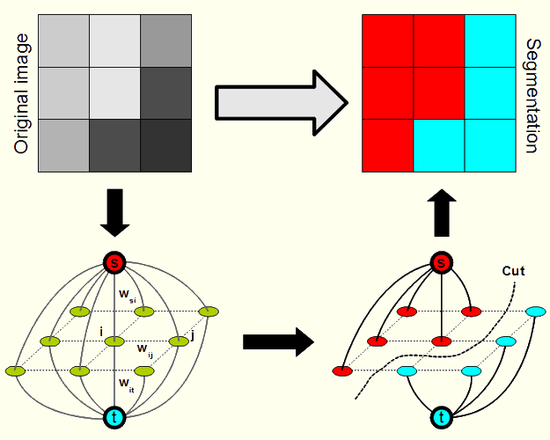

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.mixture import GaussianMixture
from networkx.algorithms.flow import shortest_augmenting_path
import networkx as nx
from PIL import Image as im 

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_RBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_RBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [3]:
def get_predictions(img,mask,components):
    rows,cols,_ = img.shape
    
    mask = mask.reshape(rows*cols)
    
    bg = np.where(mask==0)
    fg = np.where(mask==1)
    
    img = img.reshape(rows*cols,3)
        
    bgmm = GaussianMixture(n_components=components, random_state=0)
    bgmm.fit(img[bg])
    b = bgmm.predict(img)
    b = b.reshape(rows,cols)
            
#     print(np.unique(b))
        
    b_values = []
    b_values.append(bgmm.weights_)
    b_values.append(bgmm.means_)
    b_values.append(bgmm.covariances_)
    
        
    fgmm = GaussianMixture(n_components=components, random_state=0)
    fgmm.fit(img[fg])
    f = fgmm.predict(img)
    f = f.reshape(rows,cols)
    
#     print(np.unique(f))
    
    f_values = []
    f_values.append(fgmm.weights_)
    f_values.append(fgmm.means_)
    f_values.append(fgmm.covariances_)
    
    return b,f,b_values,f_values

In [4]:
def cal_d(predict, l, img):
    rows,cols,_ = img.shape
    weights,mean,covariances = l
    
    d = np.zeros([rows,cols], np.uint8)
    
    for i in range(rows):
        for j in range(cols):
            temp = predict[i][j]
            x = -np.log(weights[temp])
            y = 0.5*np.log(np.linalg.det(covariances[temp]))
            z = np.subtract(img[i][j],mean[temp])
            p = np.dot(z.T,np.linalg.inv(covariances[temp]))
            p = 0.5*np.dot(p,z)
            d[i][j] = x + y + p
            
    return d

In [5]:
def cal_beta(img):
    beta = 1
    temp1 = np.sum(np.square(np.subtract(img[:-1,:],img[1:,:])))
    temp2 = np.sum(np.square(np.subtract(img[:,:-1],img[:,1:])))

    temp1 = (2*(temp1+temp2))/(img.shape[0]*img.shape[1])
    beta = 1/temp1
    return beta

In [6]:
def main(mask,img,gamma,components):
    
    rows, cols, _ = img.shape    
    
    b_predict, f_predict, b_values, f_values = get_predictions(img,mask,components)
    
    d_values_for_bck = cal_d(b_predict,b_values,img)
    d_values_for_front = cal_d(f_predict,f_values,img)
    
    beta = cal_beta(img) # 0-1
    
    G=nx.Graph()
    
    G.add_node("source")
    G.add_node("sink")
    
    for i in range(rows):
        for j in range(cols):
            G.add_node(i*cols+j)
            if mask[i][j]==0:
                G.add_edge("source", i*cols+j, capacity=0)
                G.add_edge(i*cols+j, "sink")
            else:
                G.add_edge("source", i*cols+j, capacity=d_values_for_bck[i][j])
                G.add_edge(i*cols+j, "sink", capacity=d_values_for_front[i][j])
        
    for i in range(rows):
        for j in range(cols):
            if i!=rows-1:
                temp = gamma*np.exp(-beta*np.sum(np.square(np.abs(img[i][j]-img[i+1][j]))))
                G.add_edge(i*cols+j,(i+1)*cols+j,capacity=temp)
                G.add_edge((i+1)*cols+j,i*cols+j,capacity=temp)
            
            if j!=cols-1:
                temp = gamma*np.exp(-beta*np.sum(np.square(np.abs(img[i][j]-img[i][j+1]))))
                G.add_edge(i*cols+j,i*cols+j+1,capacity=temp)
                G.add_edge(i*cols+(j+1),i*cols+j,capacity=temp)
               
                
    _, partition = nx.minimum_cut(G, "source", "sink",flow_func=shortest_augmenting_path)
    
    p0 = list(partition[0])
    p1 = list(partition[1])
    
    if "source" in p0:
        p0.remove("source")
    if "sink" in p0:
        p0.remove("sink")
    if "source" in p1:
        p1.remove("source")
    if "sink" in p1:
        p1.remove("sink")
        
    mask2 = np.zeros(rows*cols, dtype=np.uint8)
       
    mask2[p0] = 1
    mask2[p1] = 0 
    
    
    mask2 = mask2.reshape(rows,cols)
    
    return mask2

In [7]:
def run(filename: str,gamma=50,components=5,itr=5):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    
    flag = True
        

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented output', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            if flag:
                flag = False
                x1,y1,w,h = FLAGS['RECT']
                mask1 = np.zeros(img.shape[:2], dtype = np.uint8) 
                mask1 = mask.copy()
                mask1[y1:y1+h,x1:x1+w] = 1

                for _ in range(itr):
                    mask1 = main(mask1,img,gamma,components)    
                    mask[:,:] = np.copy(mask1)
                    EventObj.flags = FLAGS
                    mask2 = np.where((mask == 1), 255, 0).astype('uint8')
                    output = cv2.bitwise_and(img2, img2, mask = mask2)  

                    temp = im.fromarray(output) 
                    s = '../images/results'+"/"+(str(filename.split("/")[3]))
                    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
                    plt.xticks([])
                    plt.yticks([])
                    plt.savefig(s)
                    plt.show()  
                
            else:
                mask1 = mask.copy()
                for _ in range(itr):
                    mask1 = main(mask1,img,gamma,components)
            
            mask[:,:] = np.copy(mask1)
            EventObj.mask = mask
        
        
        EventObj.flags = FLAGS
        mask2 = np.where((mask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)  
        
           
    temp = im.fromarray(output) 
    s = '../images/results'+"/"+(str(filename.split("/")[3]))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.savefig(s)
    plt.show()        

In [8]:
def resize_image(filename):
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    scale_percent = 40 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    data = im.fromarray(resized) 
    l = filename.split("/")
    s = l[0]+"/"+l[1]+"/"+"resized"+"/"+l[2]
    data.save(s)
    return s

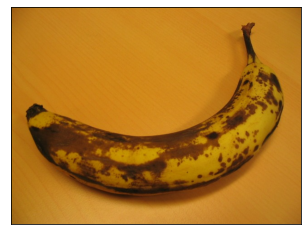

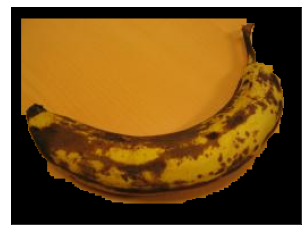

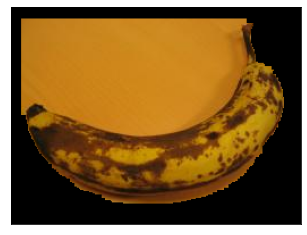

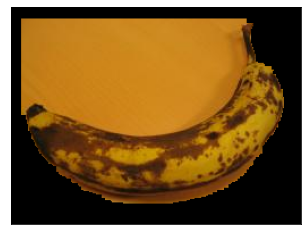

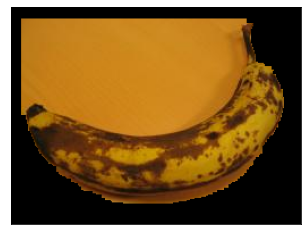

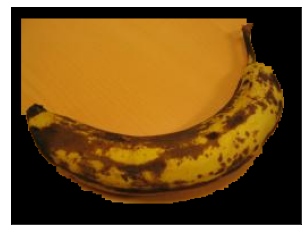

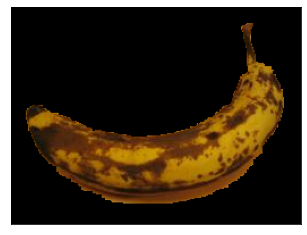

In [12]:
if __name__ == '__main__':
    filename = '../images/banana1.jpg'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=50,components=5,itr=5)
    cv2.destroyAllWindows()

__Observations__:

- Here we can observe that number of iterations didn't make any difference
- After giving the stroke, it has converged well

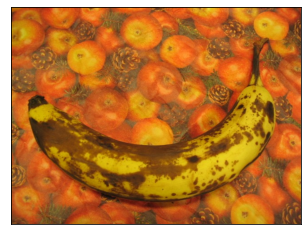

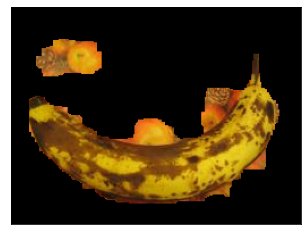

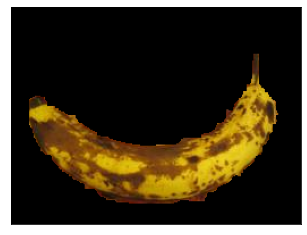

In [14]:
if __name__ == '__main__':
    filename = '../images/banana2.jpg' 
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=5,components=5,itr=1)
    cv2.destroyAllWindows()

__Observation__:

- Here the output what we want is almost attained in the first iteration
- Strokes were used to reomve the extra part

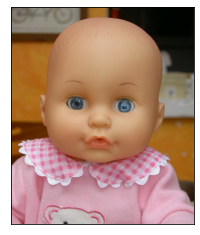

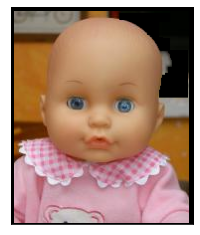

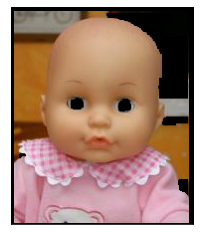

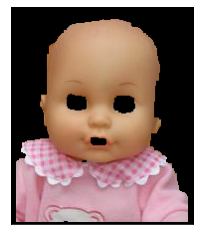

In [19]:
if __name__ == '__main__':
    filename = '../images/doll.jpg' 
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=10,components=3,itr=2)
    cv2.destroyAllWindows()

__Observation__:

- The more the iterations the more tha object is getting converged and the more the increase in black pixels
- Here as the number of different objects is less. We can give less number of components in the GMM

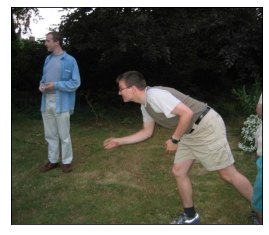

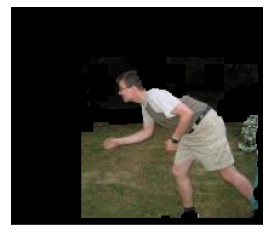

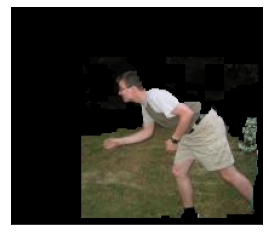

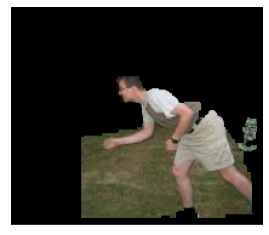

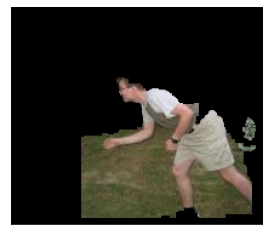

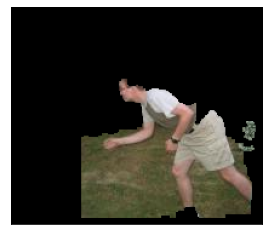

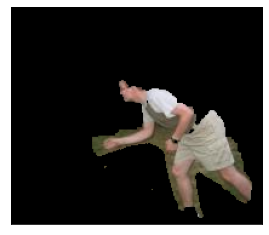

In [20]:
if __name__ == '__main__':
    filename = '../images/bool.jpg' 
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=5,components=5,itr=5)
    cv2.destroyAllWindows()

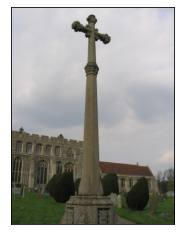

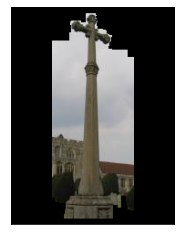

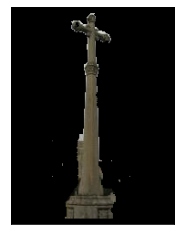

In [23]:
if __name__ == '__main__':
    filename = '../images/cross.jpg' 
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=5,components=2,itr=1)
    cv2.destroyAllWindows()

__Observation__:

- Even here the number of iterations doesn't matter
- It got converged in the 1st ieration itself
- After strokes the result is obtained

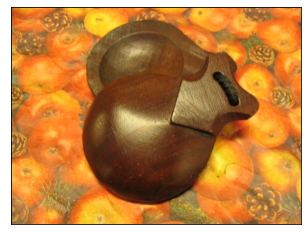

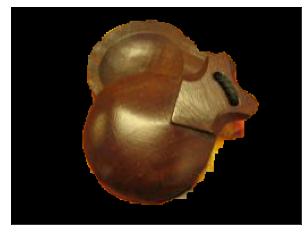

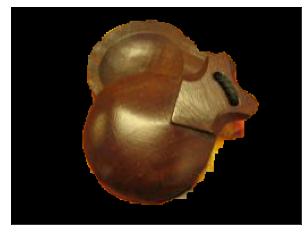

In [25]:
if __name__ == '__main__':
    filename = '../images/music.jpg' 
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=5,components=10,itr=1)
    cv2.destroyAllWindows() ## no need of user i/p

__Observation__:

- Even here we will need only one teration to converge tottaly without any user strokes
- As there are different color in background number of componnets given should be more

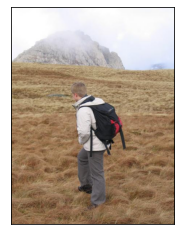

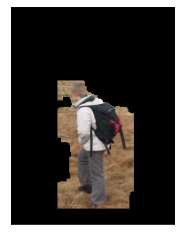

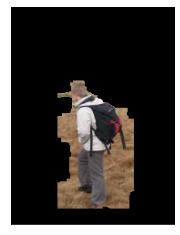

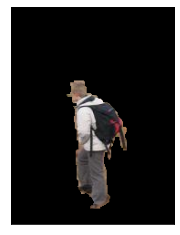

In [26]:
if __name__ == '__main__':
    filename = '../images/person3.jpg' 
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=5,components=5,itr=2)
    cv2.destroyAllWindows()

__Observation__:

- In this we can see that there will be converegnce for every iteration
- Removed the extra pixels which are not needed user strokes

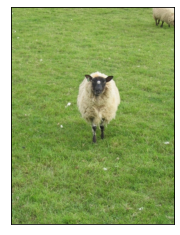

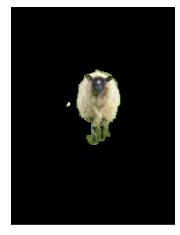

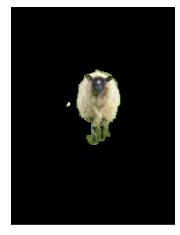

In [28]:
if __name__ == '__main__':
    filename = '../images/sheep.jpg' 
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=5,components=2,itr=1)
    cv2.destroyAllWindows()

__Observation__:

- Even here we don't need much iterations and much user interaction 
- As the bounding box is very less the task became easier

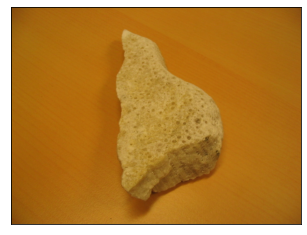

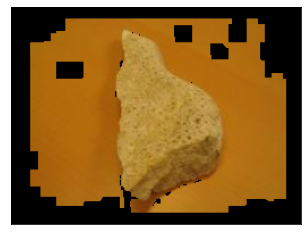

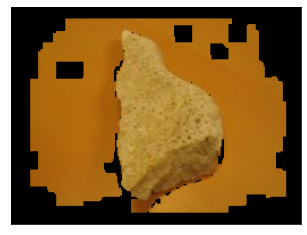

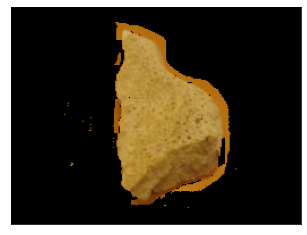

In [9]:
if __name__ == '__main__':
    filename = '../images/stone1.jpg' 
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=5,components=10,itr=2)
    cv2.destroyAllWindows()

__Observation__:

- As the number of iteration increases the convergence did increase and it is not getting converged after a cerain iteration
- Using the strokes we could extract the object

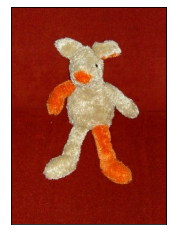

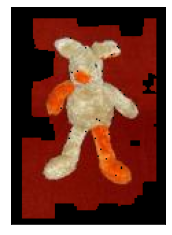

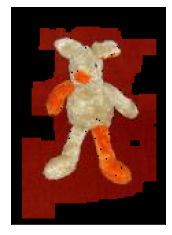

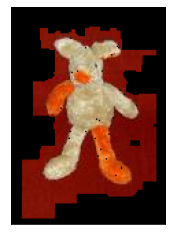

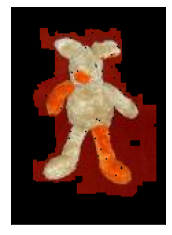

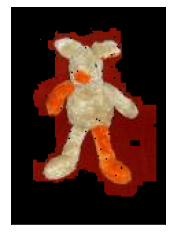

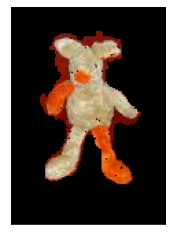

In [10]:
if __name__ == '__main__':
    filename = '../images/teddy.jpg' 
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    filename = resize_image(filename)
    run(filename,gamma=5,components=10,itr=5)
    cv2.destroyAllWindows()

__Observation__:

- As the number of iteration increases the convergence did increase and it is not getting converged after a cerain iteration
- Using the strokes we could extract the object

# Analysis




## 1. The number of Gaussian Mixture Components

- Increasing the number of Gaussian Mixture components helps us in learning and representing a wider range of colors for the foreground and background.
- If the number of components is very low, it may result in incorrectly categorizing many foreground pixels if the foreground object shows wide variation in color combination
- At the same time if there are too many components there can be additional background pixels present in the segmentation of foreground object.
- This is a hyper parameter that has to be tuned experimentally and there is no perfect rule for deciding the parameter.


## 2. Number of iterations

- Increase in the number of iterations we get more and more perfect segmentation of the foreground object until it converges.


## 3. Varying Gamma

- Varying gamma is responsible for giving the pairwise potential values between any two pixels.
- It is a hyper parameter which has to be determined experimentally
- Too low a value or too high a value can wrongly categorise the foreground pixels
- Typically a value of 50 or 100 gave us decent results.


## 4. A Tight or Loose initial bounding box

- A tighter initial bounding box results in a more stricter supervision and hence a more accurate segmentation of the foreground object from the background.
- A loose initial bounding box will result in a weaker supervision and hence a lot of background pixels would be present in the region of interest which wouldn’t be learned as a part of background model and hence we won’t get a very accurate segmentation.